In [ ]:
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS, OptimizerLRScheduler
!pip install pytorch-lightning

# MNIST

## Load data

In [1]:
from torchvision import datasets, transforms
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torch

In [2]:
class MnistDataModule(pl.LightningDataModule):
    def __init__(self, batch_size = 32):
        super().__init__()
        self.batch_size = batch_size
    
    def setup(self, stage = None):
        transform = transforms.Compose([transforms.ToTensor(), \
                                transforms.Normalize((0), (1))
                                ])
        
        self.train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
        self.test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size = self.batch_size, shuffle=False)


In [3]:
dm = MnistDataModule()

In [4]:
dm.setup()

In [5]:
image = dm.train_dataset[0][0]

In [6]:
image

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [7]:
image.shape

torch.Size([1, 28, 28])

In [8]:
import matplotlib.pyplot as plt

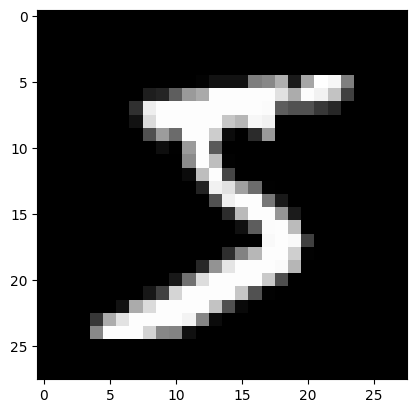

In [9]:
plt.imshow(image.reshape(28,28), cmap='gray')

## Model

### Convolutional layers

In [2]:
from torch.nn import Conv2d

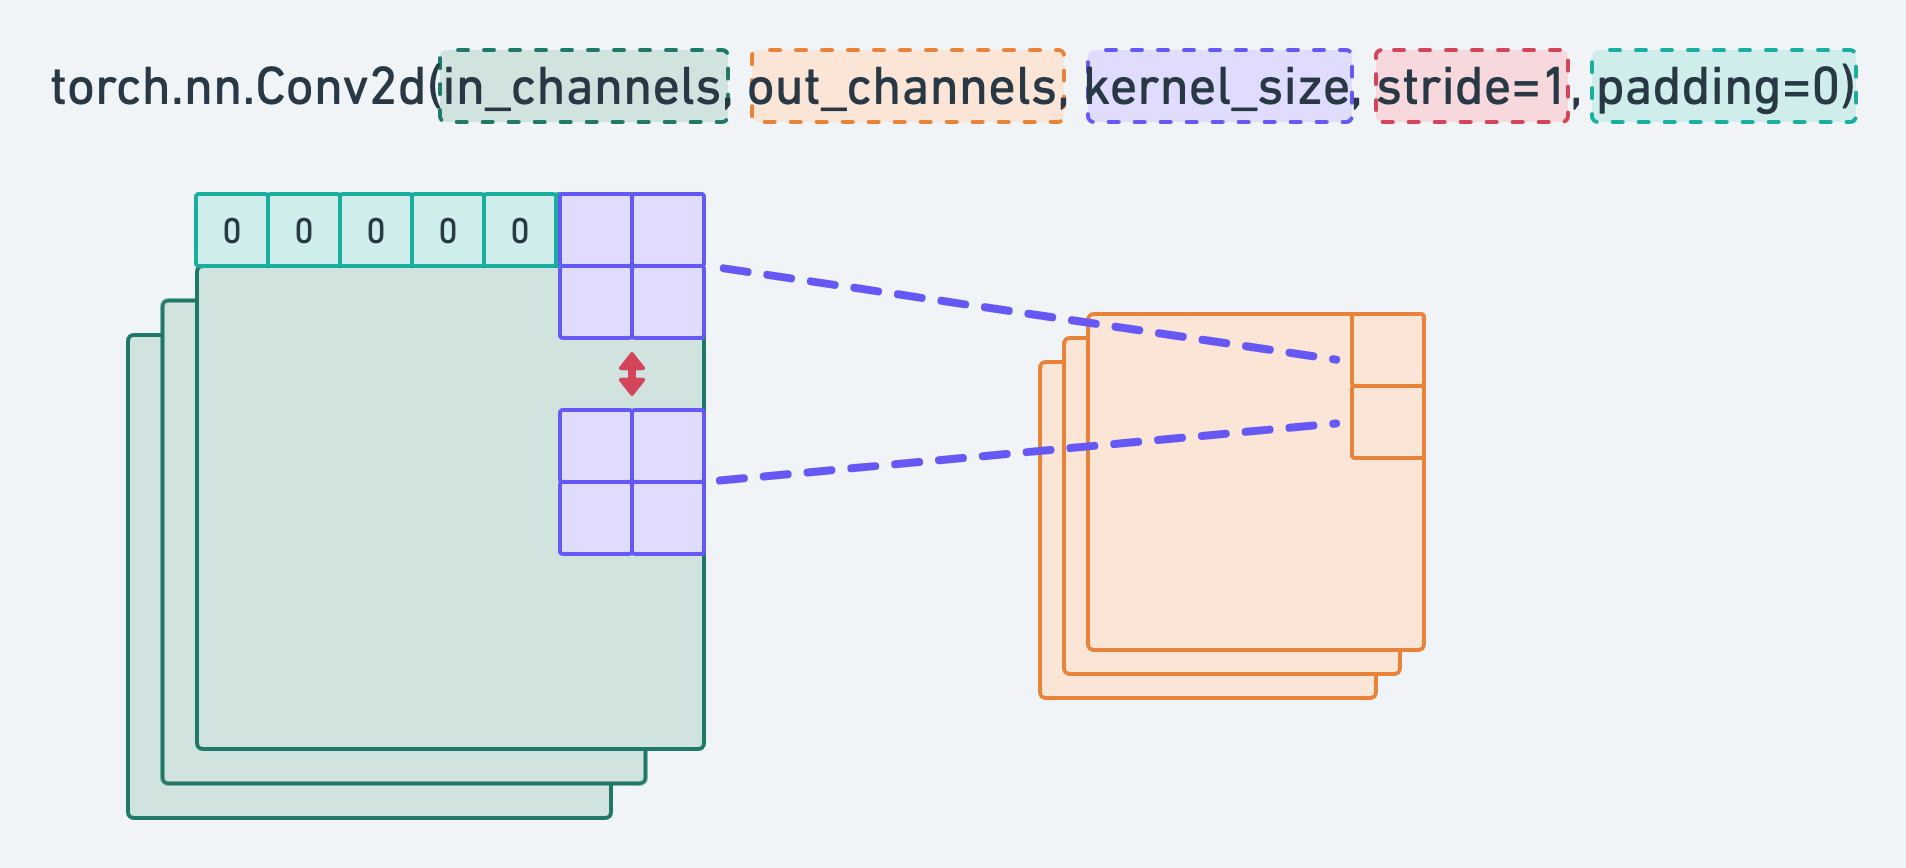

In [3]:
from torch import nn
import torch.nn.functional as F
from torch import optim
import torchmetrics

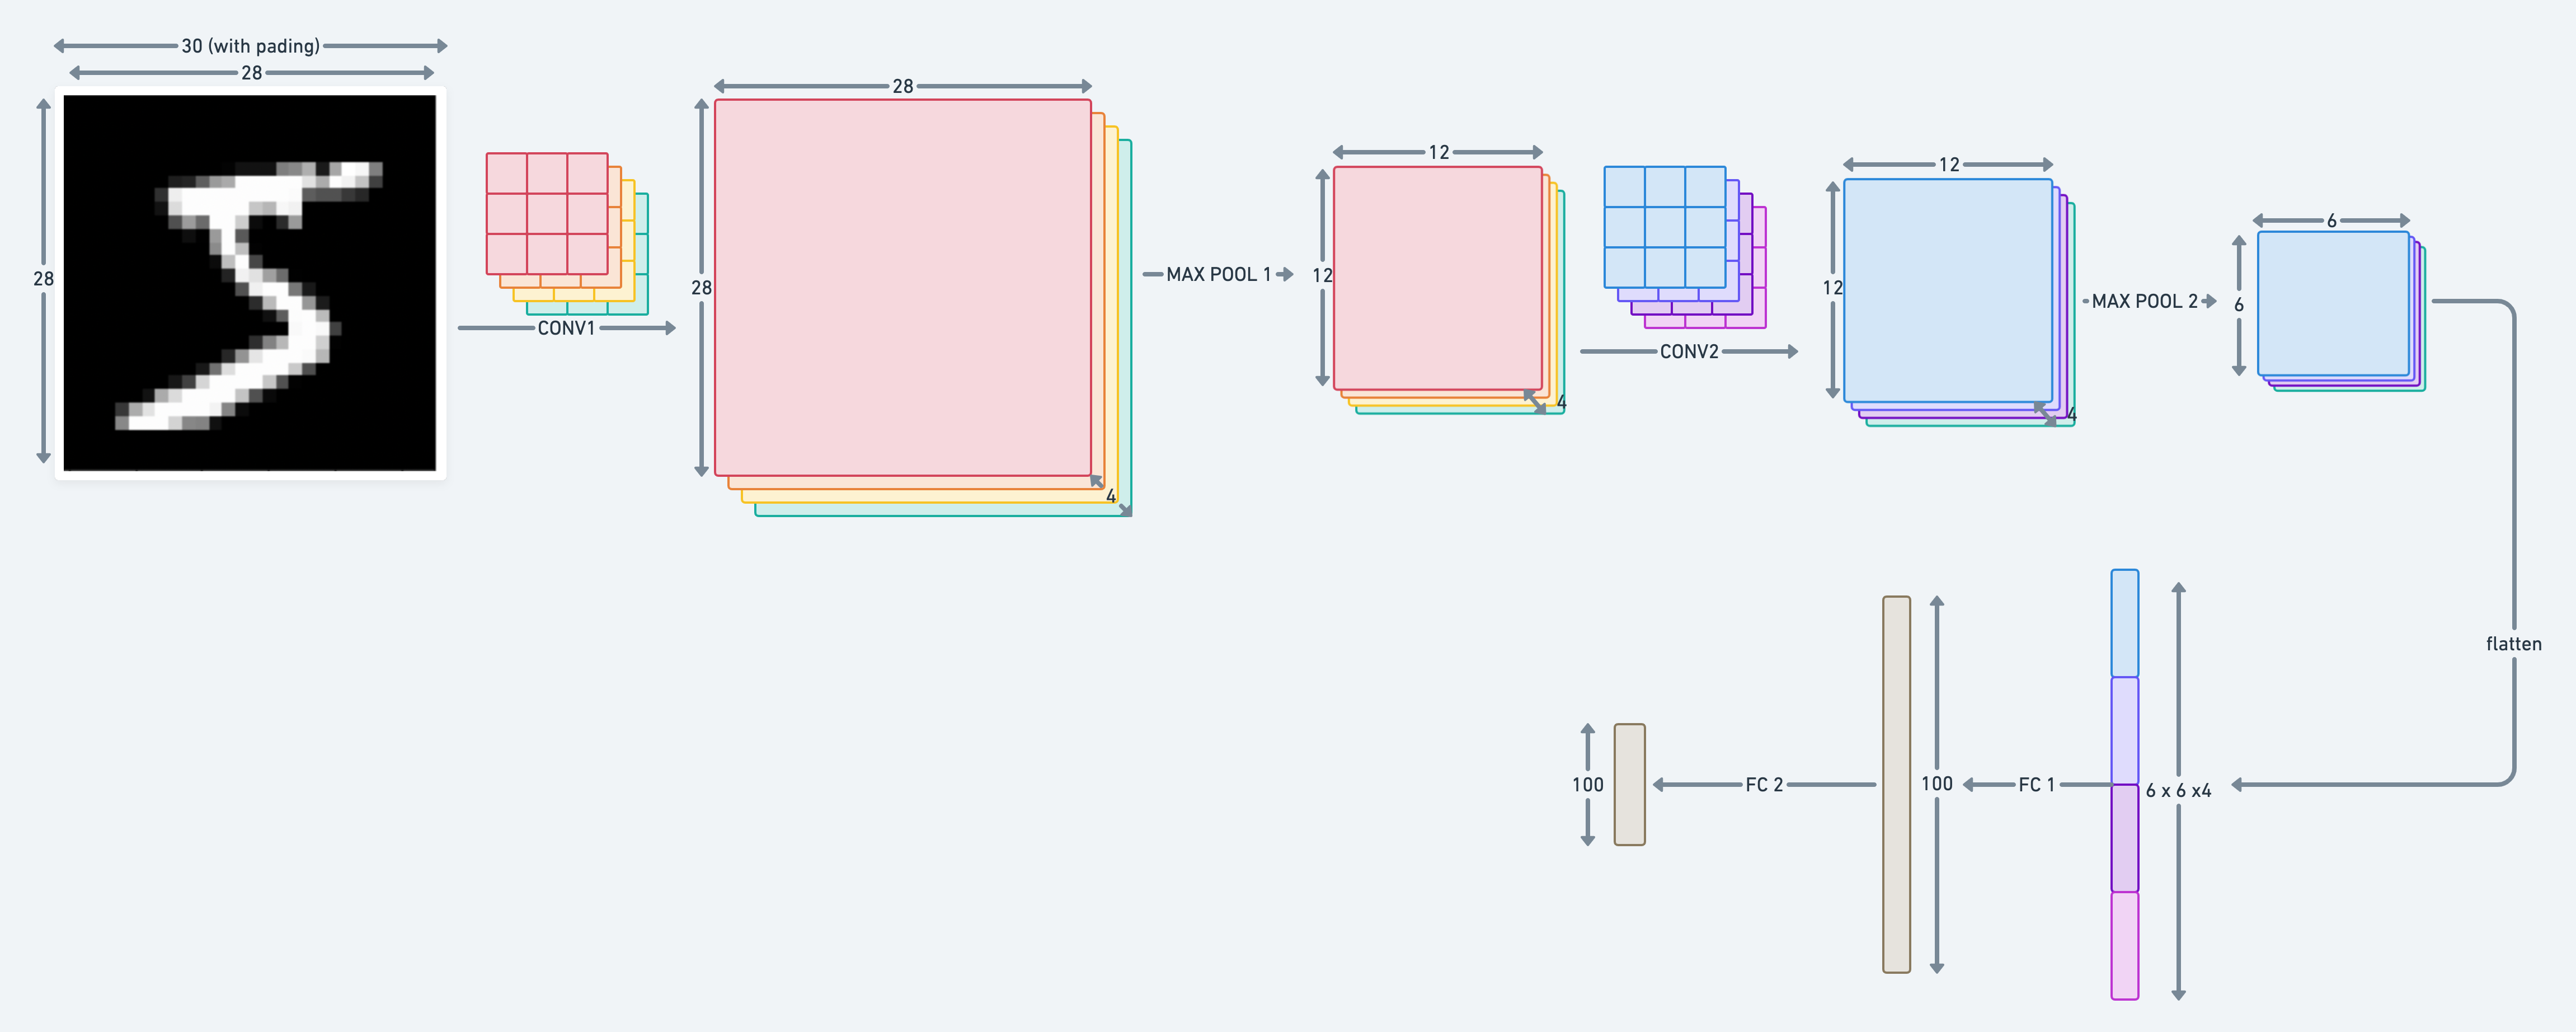

In [30]:
class MnistModel(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        
        self.loss_function = nn.CrossEntropyLoss()
        
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(4)
        self.max_pool_1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(4)
        self.max_pool_2 = nn.MaxPool2d(2)
        
        self.fc_1 = nn.LazyLinear(100)
        self.fc_2 = nn.LazyLinear(10)
        
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        
        self.train_macro_f1 = torchmetrics.F1Score(num_classes=num_classes,task="multiclass" , average='macro')
        self.val_macro_f1 = torchmetrics.F1Score(num_classes=num_classes,task="multiclass" , average='macro')
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.max_pool_1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.max_pool_2(out)
        
        out = self.flat(out)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc_2(out)
        
        return out
    
    def configure_optimizers(self):
        optimizer =  optim.SGD(self.parameters(), lr = 0.01)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        inputs, labels = train_batch
    
    
        outputs = self.forward(inputs.float())
        loss = self.loss_function(outputs, labels)
    
        self.log('train_loss', loss, on_step= True, on_epoch = True)
    
        outputs = F.softmax(outputs, dim =1)
    
        self.train_acc(outputs, labels)
        self.log('train_acc', self.train_acc, on_epoch=True, on_step= False)
    
        self.train_macro_f1(outputs, labels)
        self.log('train_macro_f1', self.train_macro_f1, on_epoch=True, on_step= False)
    
    
        return loss

    def validation_step(self, val_batch, batch_idx):
        inputs, labels = val_batch
    
    
        outputs = self.forward(inputs.float())
        loss = self.loss_function(outputs, labels)
    
        self.log('val_loss', loss,  on_step= True, on_epoch = True)
    
    
        outputs = F.softmax(outputs, dim =1)
    
        self.val_acc(outputs, labels)
        self.log('val_acc', self.val_acc, on_epoch=True, on_step= False)
    
        self.val_macro_f1(outputs, labels)
        self.log('val_macro_f1', self.val_macro_f1, on_epoch=True, on_step= False)
    
        return loss

In [31]:
mnist_model = MnistModel(10)

In [32]:
from pytorch_lightning.loggers import TensorBoardLogger

In [33]:
logger = TensorBoardLogger("lightning_logs", name="mnist model")

In [34]:
trainer = pl.Trainer(accelerator="gpu",devices=1, logger = logger, max_epochs = 15, log_every_n_steps =1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [35]:
trainer.fit(mnist_model, dm)

Missing logger folder: lightning_logs\mnist model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type               | Params | Mode 
---------------------------------------------------------------
0  | loss_function  | CrossEntropyLoss   | 0      | train
1  | conv1          | Conv2d             | 40     | train
2  | bn1            | BatchNorm2d        | 8      | train
3  | max_pool_1     | MaxPool2d          | 0      | train
4  | conv2          | Conv2d             | 148    | train
5  | bn2            | BatchNorm2d        | 8      | train
6  | max_pool_2     | MaxPool2d          | 0      | train
7  | fc_1           | LazyLinear         | 0      | train
8  | fc_2           | LazyLinear         | 0      | train
9  | relu           | ReLU               | 0      | train
10 | flat           | Flatten            | 0      | train
11 | train_acc      | MulticlassAccuracy | 0      | train
12 | val_acc        | MulticlassAccuracy | 0      | train
13 | train_macro_f1 | Multiclas

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [4]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 23264), started 17:06:47 ago. (Use '!kill 23264' to kill it.)

# Exercises

https://drive.google.com/uc?id=1WKDTw02e504JR5gPBjECQEFWLCLehGaa

## Excercise 1
Complete the Animals DataModule:

1.1 Complete the image transformation function and perform the given operations:
- [ ] crop the images to 200 x 200 so that only the center remains
- [ ] convert image to tensor
- [ ] normalize to the range 0-1

2. Add methods with dataloaders:
- [ ] Train dataloader
- [ ] val dataloader

In [8]:
from torchvision.datasets import ImageFolder
from torchvision.transforms.transforms import Compose, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

In [9]:
class AnimalsDataModule(pl.LightningDataModule):
    def __init__(self, batch_size = 32):
        super().__init__()
        self.batch_size = batch_size
        self.transform = Compose([
            CenterCrop(200), # crop the images to 200x200
            ToTensor(),
            Normalize([0.5], [0.5]) # normalize the image to the range 0-1 / mean
        ])
    
    def setup(self, stage: str = None) -> None:
        dataset = ImageFolder(root="./raw-img", transform=self.transform)
        print(f"Loaded {len(dataset)} images")
        
        train_size = int(0.6 * len(dataset))
        val_size = int(0.2 * len(dataset))
        test_size = len(dataset) - train_size - val_size
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(dataset, [train_size, val_size, test_size])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size = self.batch_size, shuffle=False)


In [10]:
dm = AnimalsDataModule()

In [11]:
dm.setup()

Loaded 26179 images


In [12]:
image = dm.train_dataset[0][0]

In [13]:
image.shape

torch.Size([3, 200, 200])

In [14]:
len(dm.train_dataset)

15707

## Exercise 2


Complete the architecture of the model consisting of two convolutional blocks and two fully-connected layers
- [ ] first convolutional block: Conv2D (4 channels output, stride = 1, padding = 1) -> Batch Norm -> MaxPool
- [ ] second convolution block: Conv2D (4 channels output stride = 1, padding = 1) -> Batch Norm -> MaxPool
- [ ] first fully-connected layer: 100 neurons at the output
- [ ] second layer fully-connected

## Exercise 2*
Calculate the number x - the number of channels at the output in the 1st and 2nd convolutional layers


Output size formula for convolutional layer and maxpool
$size_{out} = \frac{size_{in} - kernel + 2 \cdot padding}{stride} + 1$

In [30]:
from torch import nn
import torch.nn.functional as F
import torchmetrics

In [31]:
class AnimalsClassifier(nn.Module):
    def __init__(self):
        super(AnimalsClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=4)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=4)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.input_size = 4 * 50 * 50
        self.fc1 = nn.Linear(in_features=self.input_size, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=10)
        
    def forward(self, x):
        out = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        out = self.pool2(F.relu(self.bn2(self.conv2(out))))
        
        # adaptation to the dimensions of the last pooling
        out = out.view(-1, self.input_size)
        
        # fully-connected 1
        out = F.relu(self.fc1(out))
        
        # fully-connected 2
        out = self.fc2(out)
        
        return out

## Exercise 3 - add validation step

#### Model

In [32]:
from torch import optim

In [33]:
class AnimalsModel(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        
        self.loss_function = nn.CrossEntropyLoss()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=4)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=4)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.input_size = 4 * 50 * 50
        self.fc1 = nn.Linear(in_features=self.input_size, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=10)
        
        self.train_acc = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")
        self.val_acc = torchmetrics.Accuracy(num_classes=num_classes, task="multiclass")

        self.train_macro_f1 = torchmetrics.F1Score(num_classes=num_classes,task="multiclass" , average='macro')
        self.val_macro_f1 = torchmetrics.F1Score(num_classes=num_classes,task="multiclass" , average='macro')
    
    def forward(self, x):
        out = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        out = self.pool2(F.relu(self.bn2(self.conv2(out))))
        
        # adaptation to the dimensions of the last pooling
        out = out.view(-1, self.input_size)
        
        # fully-connected 1
        out = F.relu(self.fc1(out))
        
        # fully-connected 2
        out = self.fc2(out)
        
        return out
    
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr = 0.001)
    
    def training_step(self, train_batch, batch_idx):
        inputs, labels = train_batch
        
        outputs = self.forward(inputs.float())
        loss = self.loss_function(outputs, labels)
    
        self.log('train_loss', loss, on_step= True, on_epoch = True)
    
        outputs = F.softmax(outputs, dim =1)
    
        self.train_acc(outputs, labels)
        self.log('train_acc', self.train_acc, on_epoch=True, on_step= False)
    
        self.train_macro_f1(outputs, labels)
        self.log('train_macro_f1', self.train_macro_f1, on_epoch=True, on_step= False)

        return loss

    def validation_step(self, val_batch, batch_idx):
        inputs, labels = val_batch
        outputs = self.forward(inputs.float())
    
        loss = self.loss_function(outputs, labels)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
    
        outputs = F.softmax(outputs, dim=1)
        self.val_acc(outputs, labels)
        self.log('val_acc', self.val_acc, on_epoch=True, prog_bar=True)
    
        self.val_macro_f1(outputs, labels)
        self.log('val_macro_f1', self.val_macro_f1, on_epoch=True, prog_bar=True)
    
        return {'val_loss': loss, 'val_acc': self.val_acc, 'val_macro_f1': self.val_macro_f1}


In [34]:
animals_model = AnimalsModel(10)

In [35]:
from pytorch_lightning.loggers import TensorBoardLogger

In [36]:
logger = TensorBoardLogger("lightning_logs", name="mnist model")

In [37]:
trainer = pl.Trainer(accelerator="gpu",devices=1, logger = logger, max_epochs = 15, log_every_n_steps =1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [38]:
trainer.fit(animals_model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type               | Params | Mode 
---------------------------------------------------------------
0  | loss_function  | CrossEntropyLoss   | 0      | train
1  | conv1          | Conv2d             | 112    | train
2  | bn1            | BatchNorm2d        | 8      | train
3  | pool1          | MaxPool2d          | 0      | train
4  | conv2          | Conv2d             | 148    | train
5  | bn2            | BatchNorm2d        | 8      | train
6  | pool2          | MaxPool2d          | 0      | train
7  | fc1            | Linear             | 1.0 M  | train
8  | fc2            | Linear             | 1.0 K  | train
9  | train_acc      | MulticlassAccuracy | 0      | train
10 | val_acc        | MulticlassAccuracy | 0      | train
11 | train_macro_f1 | MulticlassF1Score  | 0      | train
12 | val_macro_f1   | MulticlassF1Score  | 0      | train
---------------------------------------------------------------
1.0 M     Trainab

Loaded 26179 images


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Kubus\my_projects\pytorch_tutor\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


In [39]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 23264), started 23:14:01 ago. (Use '!kill 23264' to kill it.)